<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/MSDS458_Assignment_01_v26_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 1:

* In this notebook, we will build a `DNN` model for classifying MNIST digits. The `DNN` model will consist of 784 input nodes, a hidden layer with 128 nodes and 10 output nodes (corresponding to the 10 digits). 
* We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. 
* After training and evaluating our `DNN` model we analyze its performance. In particular, we use confusion matrices to compare the `predicted classes` with the `class labels` to try to determine why some images were misclassified by the model.
* We then obtain the 60,000 `activation values` of one of the hidden nodes for the (original) set of training data. We want to use these `activation values` as "proxies" for the predicted classes of the 60,000 images. 
* And just like we compared the `predicted classes` with the `class labels` using confusion matrices to determine the efficacy of the model, we use `box plots` to visualize the relationship between the `activation values` of one hidden node and the `class labels`. We don't expect these activation values to have much "predictive power". In fact, the same activation values can be associated with multiple class labels resulting in a lot of overlap in the `box plots`.
* We also perform similar experiments comparing the values at two pixel locations in the images with the class labels. This time we use `scatter plots` to visualize the relationship between the pair of pixel values with the class labels (represented by different colored dots).
* Pixel values at two locations in image should not have much predictive value. To improve on this approach, we the PCA decomposition on both the raw data of 784 pixel values and 128 hidden node activation values to reduce the number of features to 2 in each case. Once again, we use a `scatter plot` to visualize the correlation between the two principal component values and the class labels.
*  Finally, we use a Random Forest Classifier to find the relative importance of the 784 features (pixels) in the training set. We then select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Importing Packages 

* First we import all the packages that will be used in the assignment.

* Since Keras is integrated in TensorFlow 2.x, we import `keras` from `tensorflow` and use `tenserflow.keras.xxx` to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True) 

## Verify TensorFlow version and Keras version

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Research Assignment Reporting Functions

In [7]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

# Loading MNIST Dataset

* The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. Use the `tf.keras.datasets.mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [8]:
## Load MNIST data and split into test and train sets

(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

# EDA Training and Test Sets

* Inspect the training and test sets as well as their labels as follows.

In [9]:
## Number of samples in each set

print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


# EDA

## Review labels for training set

In [10]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



## Find frequency of each label in training and test sets

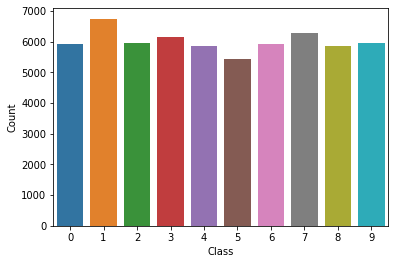

In [11]:
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [12]:
Counter(y_train).most_common()

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

In [13]:
Counter(y_test).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

## Plot sample images with their labels

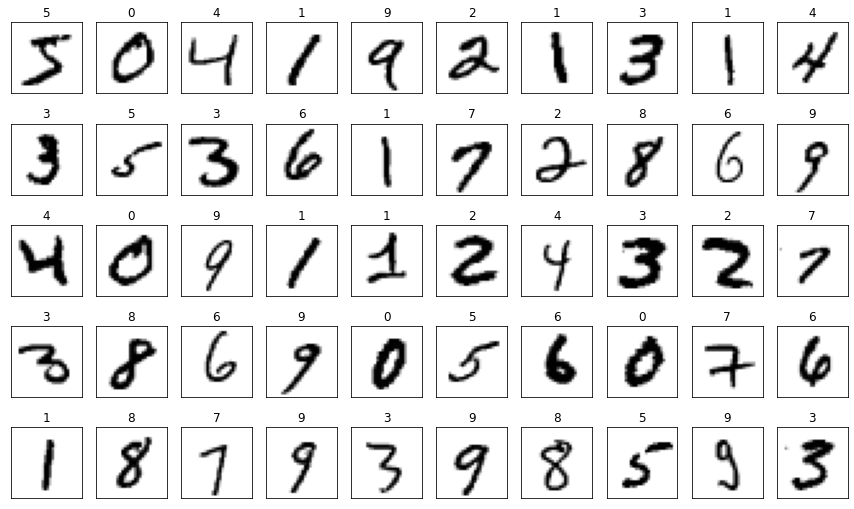

In [14]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

# Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s. 
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

## Apply one-hot encoding on the labels

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [15]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [16]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


## Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [17]:
# Before reshape:
print('x_train:\t{}'.format(x_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))

x_train:	(60000, 28, 28)
x_test:		(10000, 28, 28)


In [18]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

In [19]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

## Review unique values with set from 1st image

In [20]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}



## Rescale the elements of the reshaped images

Rescale the elements between [0 and 1]

In [21]:
## Normalize: convert pixels in range [0,255] to range [0,1], scales all images to the same size

x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [22]:
# Take a look at the first reshaped and normalized training image:
print(set(x_train_norm[0]))

{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.41960785, 0.25882354, 0.32156864, 0.21960784, 0.8039216, 0.8666667, 0.8980392, 0.7882353, 0.52156866, 0.18039216, 0.30588236, 0.44705883, 0.3529412, 0.15294118, 0.6745098, 0.88235295, 0.99215686, 0.9490196, 0.7647059, 0.2509804, 0.19215687, 0.93333334, 0.9843137, 0.74509805, 0.7294118, 0.5882353, 0.50980395, 0.8862745, 0.105882354, 0.09019608, 0.16862746, 0.13725491, 0.21568628, 0.46666667, 0.3647059, 0.27450982, 0.8352941, 0.7176471, 0.5803922, 0.8117647, 0.9764706, 0.98039216, 0.73333335, 0.42352942, 0.003921569, 0.54509807, 0.67058825, 0.5294118, 0.007843138, 0.31764707, 0.0627451, 0.09411765, 0.627451, 0.9411765, 0.9882353, 0.95686275, 0.83137256, 0.5176471, 0.09803922, 0.1764706}


In [23]:
model = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


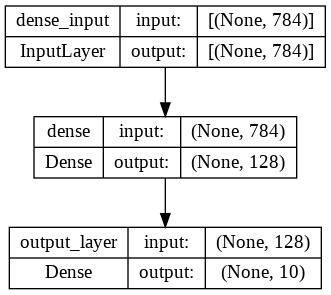

In [25]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 


<b>tf.keras.optimizers.RMSprop</b><br> 
 https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop


<b>tf.keras.losses.CategoricalCrossentropy</b><br> 
  https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy


# Experiment 1
Our dense neural network will consist of 784 input nodes, a hidden layer with 1 node and 10 output nodes (corresponding to the 10 digits). 

We use mnist.load_data() to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. 

We hold back 5,000 of the 60,000 training images for validation. 

After training the model, we group the 60,000 activation values of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a boxplot. We expect the overlap between the range of values in the "boxes" to be minimal. 

In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on CNN models in Assignment 2.

#### Build, Compile, Train, Evaluate

In [26]:
## Experiment 1 - 1 unit, 10 output units
## Build model

model_1 = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 785       
                                                                 
 output_layer (Dense)        (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________
None


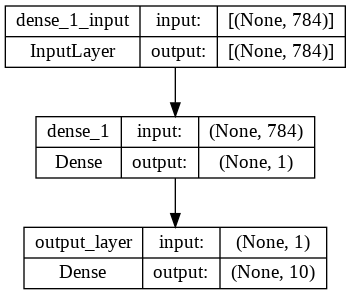

In [27]:
keras.utils.plot_model(model_1, "mnist_model.png", show_shapes=True) 

In [28]:
## Compile

model_1.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [29]:
## Train 

history_1 = model_1.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 7s 3ms/step - loss: 1.9906 - accuracy: 0.2352 - val_loss: 1.8683 - val_accuracy: 0.2538
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.8418 - accuracy: 0.2774 - val_loss: 1.7882 - val_accuracy: 0.2922
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.7846 - accuracy: 0.3062 - val_loss: 1.7371 - val_accuracy: 0.3406
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.7498 - accuracy: 0.3261 - val_loss: 1.7050 - val_accuracy: 0.3488
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.7212 - accuracy: 0.3426 - val_loss: 1.6821 - val_accuracy: 0.3367
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.6994 - accuracy: 0.3530 - val_loss: 1.6624 - val_accuracy: 0.3466


In [30]:
## Evaluate

model_1 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_1.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.6723 - accuracy: 0.3543
Test acc: 0.354


#### Activation Layer

In [31]:
# Extracts the outputs of the 2 layers:
layer_outputs_1 = [layer.output for layer in model_1.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_1 = models.Model(inputs=model_1.input, outputs=layer_outputs_1)

print(f"There are {len(layer_outputs_1)} layers")
layer_outputs_1; # description of the layers

There are 2 layers


In [32]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations_1 = activation_model_1.predict(x_train_norm)
hidden_layer_activation_1 = activations_1[0]
output_layer_activations_1 = activations_1[1]
hidden_layer_activation_1.shape   #  each of the 128 hidden nodes has one activation value per training image

1875/1875 [==============================] - 2s 1ms/step


(60000, 1)

In [33]:
output_layer_activations_1.shape

(60000, 10)

In [34]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation_1.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 14.399374961853027


In [35]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation_1 = activations_1[1]
print(f"The output node has shape {ouput_layer_activation_1.shape}")
print(f"The output for the first image are {ouput_layer_activation_1[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation_1[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.036 0.001 0.113 0.103 0.116 0.158 0.022 0.145 0.158 0.147]
The sum of the probabilities is (approximately) 0.9999999403953552


In [36]:
#Get the dataframe of all the node values
activation_data_1 = {'actual_class':y_train}
for k in range(0,1): 
    activation_data_1[f"act_val_{k}"] = hidden_layer_activation_1[:,k]

activation_df_1 = pd.DataFrame(activation_data_1)
activation_df_1.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.000,1.0,9.000,2.000,1.0,3.000,1.0,4.000,3.0,5.000,3.0,6.000,1.0
act_val_0,1.962,5.727,1.616,0.0,3.129,3.254,0.0,0.857,0.0,3.029,0.0,0.452,0.0,7.235,0.0


### Visualization

#### Boxplot

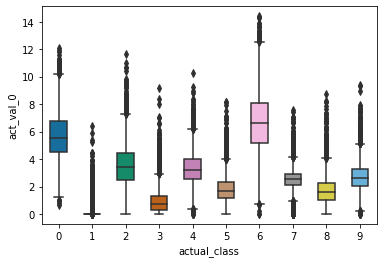

In [37]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot_1 = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df_1[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

#### Confusion Matrix

In [38]:
# Get the predicted classes:
pred_classes = np.argmax(model_1.predict(x_test_norm), axis=-1)
pred_classes;

313/313 [==============================] - 0s 1ms/step


In [39]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

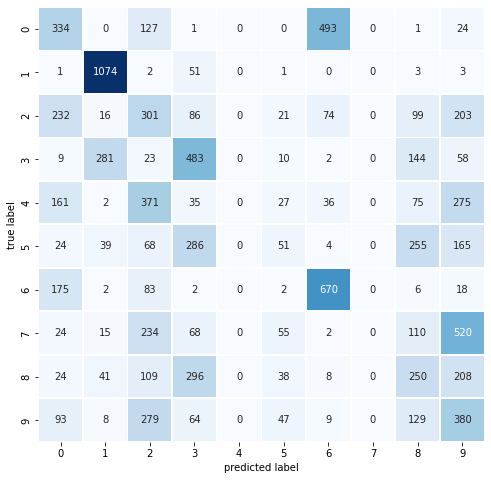

In [40]:
plot_confusion_matrix(y_test,pred_classes)

# Experiment 2
This time our dense neural network will have 784 input nodes, a hidden layer with 2 nodes and 10 output nodes (corresponding to the 10 digits). 

For each of the 60,000 images, the output of the two hidden nodes are plotted using a scatterplot. 

We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in EXPERIMENT 1, the color clusters should have very little overlap. 

Also compare the accuracy % & confusion matrix of Experiments 1 & 2. Again, the goal is to get more insights.

####Build, Compile, Train, Evaluate

In [41]:
## Experiment 2 - 2 unit, 10 output units
## Build model

model_2 = Sequential([
    Dense(input_shape=[784], units=2, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 1570      
                                                                 
 output_layer (Dense)        (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________
None


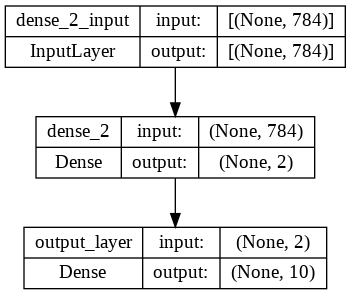

In [42]:
keras.utils.plot_model(model_2, "mnist_model.png", show_shapes=True) 

In [43]:
## Compile

model_2.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [44]:
## Train 

history_2 = model_2.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.5799 - accuracy: 0.4439 - val_loss: 1.2843 - val_accuracy: 0.5787
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.2613 - accuracy: 0.5878 - val_loss: 1.1460 - val_accuracy: 0.6122
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.1849 - accuracy: 0.6033 - val_loss: 1.0975 - val_accuracy: 0.6249
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.1483 - accuracy: 0.6124 - val_loss: 1.0656 - val_accuracy: 0.6466
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.1262 - accuracy: 0.6190 - val_loss: 1.0510 - val_accuracy: 0.6442
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.1094 - accuracy: 0.6258 - val_loss: 1.0344 - val_accuracy: 0.6506
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.0960 - accuracy: 0.6340 - val_loss: 1.0362 - val_ac

In [45]:
## Evaluate

model_2 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_2.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.0228 - accuracy: 0.6815
Test acc: 0.682


####Activation Layer

In [46]:
# Extracts the outputs of the 2 layers:
layer_outputs_2 = [layer.output for layer in model_2.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_2 = models.Model(inputs=model_2.input, outputs=layer_outputs_2)

print(f"There are {len(layer_outputs_2)} layers")
layer_outputs_2; # description of the layers

There are 2 layers


In [47]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations_2 = activation_model_2.predict(x_train_norm)
hidden_layer_activation_2 = activations_2[0]
output_layer_activations_2 = activations_2[1]
hidden_layer_activation_2.shape   #  each of the 128 hidden nodes has one activation value per training image

1875/1875 [==============================] - 2s 1ms/step


(60000, 2)

In [48]:
output_layer_activations_2.shape

(60000, 10)

In [49]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation_2.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 17.56066131591797


In [50]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation_2 = activations_2[1]
print(f"The output node has shape {ouput_layer_activation_2.shape}")
print(f"The output for the first image are {ouput_layer_activation_2[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation_2[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.142 0.02  0.036 0.661 0.    0.116 0.    0.    0.025 0.   ]
The sum of the probabilities is (approximately) 1.0000001192092896


In [51]:
#Get the dataframe of all the node values
activation_data_2 = {'actual_class':y_train}
for k in range(0,2): 
    activation_data_2[f"act_val_{k}"] = hidden_layer_activation_2[:,k]

activation_df_2 = pd.DataFrame(activation_data_2)
activation_df_2.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.000,1.000,9.000,2.000,1.000,3.000,1.000,4.000,3.000,5.000,3.000,6.000,1.000
act_val_0,5.844,6.795,1.833,2.434,1.049,3.499,3.090,5.457,2.791,0.000,6.837,2.516,7.724,0.000,2.828
act_val_1,4.605,6.789,0.714,1.673,0.000,3.784,1.431,4.330,1.380,0.399,3.244,3.274,5.101,4.634,1.646


### Visualization


#### Boxplot

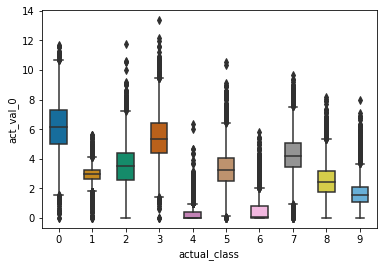

In [52]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot_2 = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df_2[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

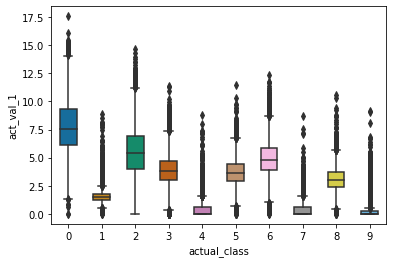

In [53]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot_2 = sns.boxplot(y='act_val_1', x='actual_class', 
                 data=activation_df_2[['act_val_1','actual_class']], 
                 width=0.5,
                 palette="colorblind")

####Scatter Plot

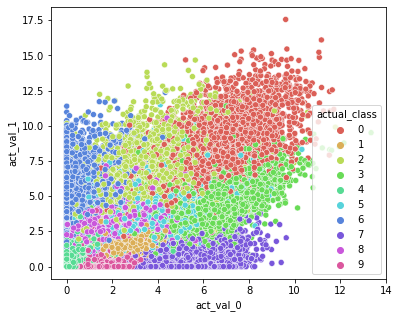

In [54]:
plt.figure(figsize=(6, 5))
color = sns.color_palette("hls", 10)

sns.scatterplot(y='act_val_1', x='act_val_0', 
                 data=activation_df_2, hue = 'actual_class',
                 palette=sns.color_palette("hls", 10),)

####Confusion Matrix

In [55]:
# Get the predicted classes:
pred_classes = np.argmax(model_2.predict(x_test_norm), axis=-1)
pred_classes;

313/313 [==============================] - 0s 1ms/step


In [56]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

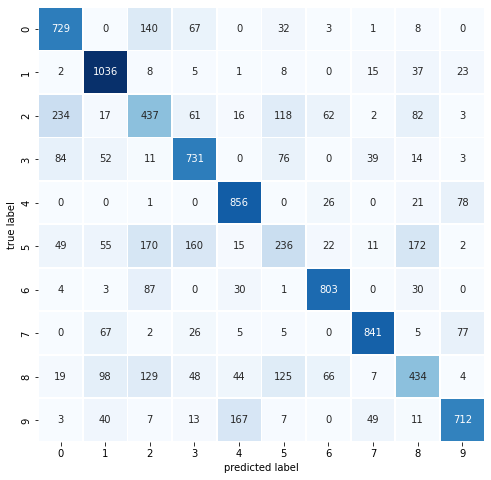

In [57]:
plot_confusion_matrix(y_test,pred_classes)

# Experiment 3
You can explore with more hidden nodes. At least 5 more variations of this architecture NEEDS to be tried. 

Then you end up with 1 ‘final’ model. Say the ‘best’ model.

### Best/final model: Variation 4.3

## Variation 1

####Build, Compile, Train, Evaluate

In [58]:
## Experiment 3, Variation 1 - 5 units, 10 output units
## Build model

model_3_1 = Sequential([
    Dense(input_shape=[784], units=5, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 3925      
                                                                 
 output_layer (Dense)        (None, 10)                60        
                                                                 
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
## Compile

model_3_1.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [60]:
## Train 

history_3_1 = model_3_1.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.9292 - accuracy: 0.7138 - val_loss: 0.5566 - val_accuracy: 0.8446
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.6001 - accuracy: 0.8302 - val_loss: 0.4805 - val_accuracy: 0.8729
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.5496 - accuracy: 0.8475 - val_loss: 0.4495 - val_accuracy: 0.8825
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.5253 - accuracy: 0.8564 - val_loss: 0.4356 - val_accuracy: 0.8880
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.5100 - accuracy: 0.8607 - val_loss: 0.4256 - val_accuracy: 0.8880
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.4985 - accuracy: 0.8641 - val_loss: 0.4134 - val_accuracy: 0.8928
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.4882 - accuracy: 0.8663 - val_loss: 0.4041 - val_ac

In [61]:
## Evaluate

model_3_1 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_1.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.4127 - accuracy: 0.8880
Test acc: 0.888


In [62]:
# Get the predicted classes:
pred_classes_3_1 = np.argmax(model_3_1.predict(x_test_norm), axis=-1)
pred_classes_3_1;

313/313 [==============================] - 0s 1ms/step


In [63]:
conf_mx_3_1 = tf.math.confusion_matrix(y_test, pred_classes_3_1)
conf_mx_3_1;

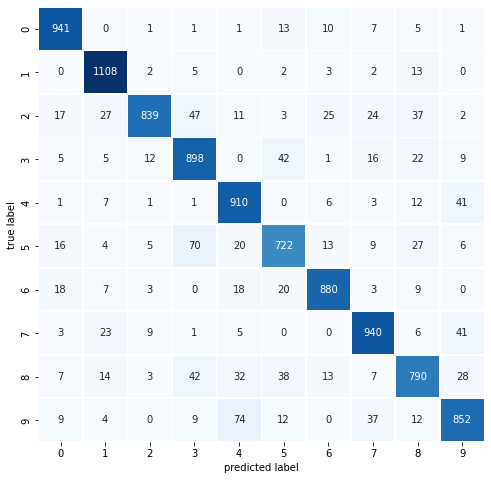

In [64]:
plot_confusion_matrix(y_test,pred_classes_3_1)

## Variation 2

####Build, Compile, Train, Evaluate

In [65]:
## Experiment 3, Variation 2 - 10 units, 10 output units
## Build model

model_3_2 = Sequential([
    Dense(input_shape=[784], units=10, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
 output_layer (Dense)        (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
## Compile

model_3_2.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [67]:
## Train 

history_3_2 = model_3_2.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.5933 - accuracy: 0.8444 - val_loss: 0.3166 - val_accuracy: 0.9253
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.3601 - accuracy: 0.9113 - val_loss: 0.2801 - val_accuracy: 0.9371
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.3301 - accuracy: 0.9190 - val_loss: 0.2722 - val_accuracy: 0.9343
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.3126 - accuracy: 0.9230 - val_loss: 0.2527 - val_accuracy: 0.9422
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.3015 - accuracy: 0.9244 - val_loss: 0.2487 - val_accuracy: 0.9400
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2944 - accuracy: 0.9258 - val_loss: 0.2359 - val_accuracy: 0.9466
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2881 - accuracy: 0.9279 - val_loss: 0.2344 - val_ac

In [68]:
## Evaluate

model_3_2 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_2.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.2810 - accuracy: 0.9300
Test acc: 0.930


In [69]:
# Get the predicted classes:
pred_classes_3_2 = np.argmax(model_3_2.predict(x_test_norm), axis=-1)
pred_classes_3_2;

313/313 [==============================] - 0s 1ms/step


In [70]:
conf_mx_3_2 = tf.math.confusion_matrix(y_test, pred_classes_3_2)
conf_mx_3_2;

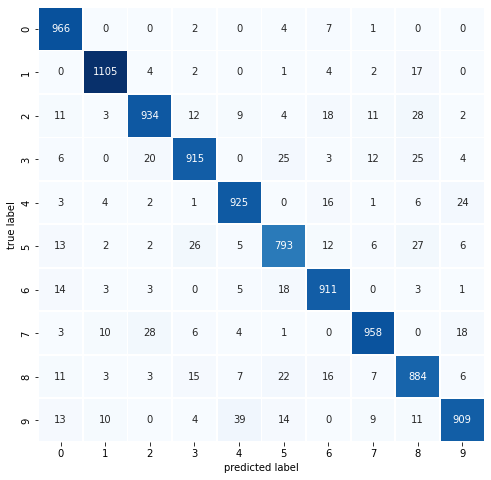

In [71]:
plot_confusion_matrix(y_test,pred_classes_3_2)

## Variation 3

####Build, Compile, Train, Evaluate

In [72]:
## Experiment 3, Variation 3 - 20 units, 10 output units
## Build model

model_3_3 = Sequential([
    Dense(input_shape=[784], units=20, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_3.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 20)                15700     
                                                                 
 output_layer (Dense)        (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
## Compile

model_3_3.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [74]:
## Train 

history_3_3 = model_3_3.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.4761 - accuracy: 0.8821 - val_loss: 0.2833 - val_accuracy: 0.9402
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.3056 - accuracy: 0.9290 - val_loss: 0.2358 - val_accuracy: 0.9494
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2729 - accuracy: 0.9366 - val_loss: 0.2204 - val_accuracy: 0.9518
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2542 - accuracy: 0.9417 - val_loss: 0.2100 - val_accuracy: 0.9538
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2411 - accuracy: 0.9434 - val_loss: 0.2010 - val_accuracy: 0.9600
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2311 - accuracy: 0.9461 - val_loss: 0.1925 - val_accuracy: 0.9610
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2241 - accuracy: 0.9479 - val_loss: 0.2009 - val_ac

In [75]:
## Evaluate

model_3_3 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_3.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.2100 - accuracy: 0.9511
Test acc: 0.951


In [76]:
# Get the predicted classes:
pred_classes_3_3 = np.argmax(model_3_3.predict(x_test_norm), axis=-1)
pred_classes_3_3;

313/313 [==============================] - 0s 1ms/step


In [77]:
conf_mx_3_3 = tf.math.confusion_matrix(y_test, pred_classes_3_3)
conf_mx_3_3;

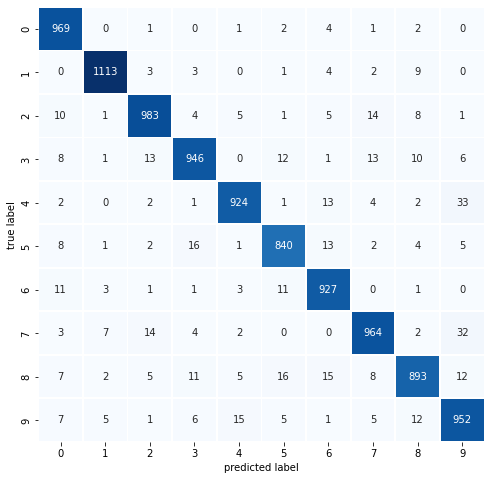

In [78]:
plot_confusion_matrix(y_test,pred_classes_3_3)

## Variation 4

####Build, Compile, Train, Evaluate

In [79]:
## Experiment 3, Variation 4 - 100 units, 10 output units
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_4.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
## Compile

model_3_4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [81]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3884 - accuracy: 0.9137 - val_loss: 0.2190 - val_accuracy: 0.9612
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2340 - accuracy: 0.9516 - val_loss: 0.1898 - val_accuracy: 0.9641
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1971 - accuracy: 0.9599 - val_loss: 0.1561 - val_accuracy: 0.9721
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1763 - accuracy: 0.9651 - val_loss: 0.1528 - val_accuracy: 0.9731
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1673 - accuracy: 0.9666 - val_loss: 0.1594 - val_accuracy: 0.9683
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1597 - accuracy: 0.9676 - val_loss: 0.1520 - val_accuracy: 0.9703


In [82]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1635 - accuracy: 0.9664
Test acc: 0.966


In [83]:
## Maing Predictions 

preds_3_4 = model_3_4.predict(x_test_norm)
print('shape of preds: ', preds_3_4.shape)

313/313 [==============================] - 0s 1ms/step
shape of preds:  (10000, 10)


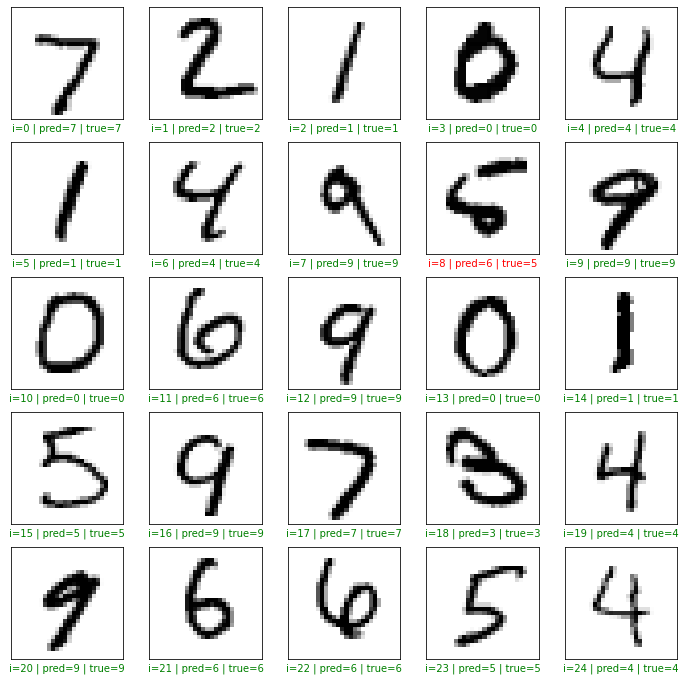

In [84]:
plt.figure(figsize = (12, 12))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds_3_4[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

In [85]:
## Review Performance 

history_dict_3_4 = history_3_4.history
history_dict_3_4.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [86]:
losses = history_3_4.history['loss']
accs = history_3_4.history['accuracy']
val_losses = history_3_4.history['val_loss']
val_accs = history_3_4.history['val_accuracy']
epochs = len(losses)

In [87]:
history_df_3_4 =pd.DataFrame(history_dict_3_4)
history_df_3_4.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,0.234,0.952,0.190,0.964
2,0.197,0.960,0.156,0.972
3,0.176,0.965,0.153,0.973
4,0.167,0.967,0.159,0.968
5,0.160,0.968,0.152,0.970


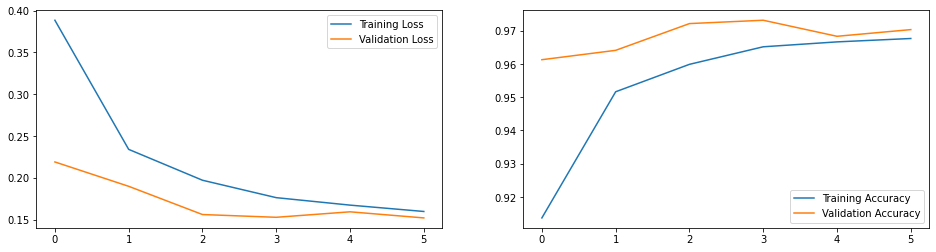

In [88]:
plot_history(history_3_4)

In [89]:
pred_3_4= model_3_4.predict(x_test_norm)
pred_3_4 =np.argmax(pred_3_4, axis=1)

print_validation_report(y_test, pred_3_4)

313/313 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.93      0.96      1032
           3       0.96      0.97      0.97      1010
           4       0.96      0.98      0.97       982
           5       0.92      0.98      0.95       892
           6       0.99      0.95      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.94      0.96       974
           9       0.98      0.95      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy Score: 0.9664
Root Mean Square Error: 0.7619055059520177


In [90]:
## Get the predicted classes:
pred_classes_3_4 = np.argmax(model_3_4.predict(x_test_norm), axis=-1)
pred_classes_3_4;

313/313 [==============================] - 0s 1ms/step


In [91]:
conf_mx_3_4 = tf.math.confusion_matrix(y_test, pred_classes_3_4)
conf_mx_3_4;

In [92]:
## Correlation Matrix
cm_3_4 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds_3_4[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm_3_4)

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.00%,0.05%,0.00%,0.00%,0.00%,99.94%,0.00%,0.01%
1,0.00%,0.02%,99.67%,0.13%,0.00%,0.11%,0.02%,0.00%,0.06%,0.00%
2,0.00%,99.79%,0.02%,0.01%,0.02%,0.02%,0.01%,0.07%,0.06%,0.01%
3,99.93%,0.00%,0.00%,0.00%,0.00%,0.05%,0.01%,0.01%,0.00%,0.00%
4,0.00%,0.00%,0.03%,0.00%,99.02%,0.01%,0.01%,0.10%,0.01%,0.83%
5,0.00%,99.95%,0.00%,0.00%,0.00%,0.00%,0.00%,0.04%,0.00%,0.00%
6,0.00%,0.00%,0.00%,0.00%,99.73%,0.10%,0.00%,0.00%,0.11%,0.06%
7,0.00%,0.00%,0.00%,0.85%,0.41%,0.03%,0.00%,0.07%,0.02%,98.62%
8,0.00%,0.00%,0.11%,0.00%,0.00%,9.04%,90.82%,0.00%,0.03%,0.00%
9,0.00%,0.00%,0.00%,0.00%,1.38%,0.01%,0.00%,0.69%,0.09%,97.82%


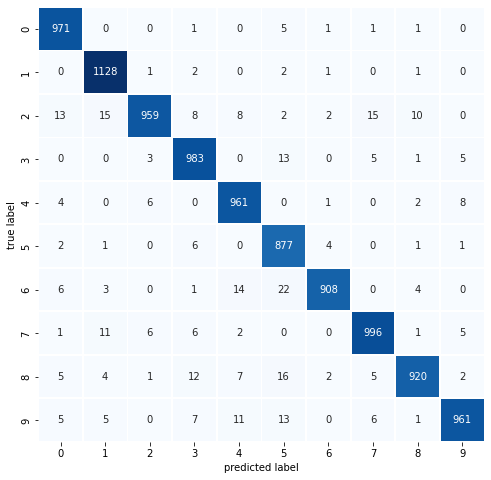

In [93]:
plot_confusion_matrix(y_test,pred_classes_3_4)

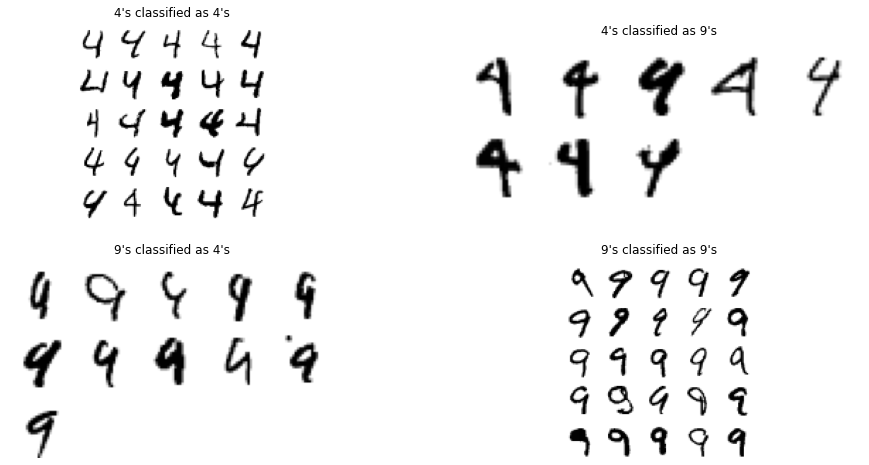

In [94]:
cl_a, cl_b = 4, 9
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes_3_4 == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes_3_4 == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes_3_4 == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes_3_4 == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);  
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

####Activation Layer

In [95]:
# Extracts the outputs of the 2 layers:
layer_outputs_3_4 = [layer.output for layer in model_3_4.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_3_4 = models.Model(inputs=model_3_4.input, outputs=layer_outputs_3_4)

print(f"There are {len(layer_outputs_3_4)} layers")
layer_outputs_3_4; # description of the layers

There are 2 layers


In [96]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations_3_4 = activation_model_3_4.predict(x_train_norm)
hidden_layer_activation_3_4 = activations_3_4[0]
output_layer_activations_3_4 = activations_3_4[1]
hidden_layer_activation_3_4.shape   #  each of the 128 hidden nodes has one activation value per training image

1875/1875 [==============================] - 3s 1ms/step


(60000, 100)

In [97]:
output_layer_activations_3_4.shape

(60000, 10)

In [98]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation_3_4.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 5.7550435066223145


In [99]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation_3_4 = activations_3_4[1]
print(f"The output node has shape {ouput_layer_activation_3_4.shape}")
print(f"The output for the first image are {ouput_layer_activation_3_4[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation_3_4[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.    0.    0.    0.014 0.    0.986 0.    0.    0.    0.   ]
The sum of the probabilities is (approximately) 1.0000001192092896


In [100]:
#Get the dataframe of all the node values
activation_data_3_4 = {'actual_class':y_train}
for k in range(0,2): 
    activation_data_3_4[f"act_val_{k}"] = hidden_layer_activation_3_4[:,k]

activation_df_3_4 = pd.DataFrame(activation_data_3_4)
activation_df_3_4.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.000,1.0,9.000,2.000,1.0,3.000,1.0,4.00,3.000,5.000,3.000,6.0,1.0
act_val_0,0.256,0.000,0.893,0.0,1.281,0.000,0.0,1.767,0.0,0.74,0.000,0.000,0.512,0.0,0.0
act_val_1,0.352,0.582,0.000,0.0,0.000,1.043,0.0,0.461,0.0,0.00,0.286,0.118,0.115,0.0,0.0


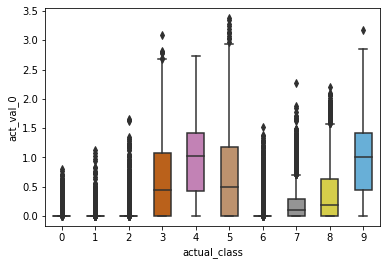

In [101]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df_3_4[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

In [102]:
activation_df_3_4.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

,actual_class,range_of_act_values
0,0,"[0.0, 0.8]"
1,1,"[0.0, 1.13]"
2,2,"[0.0, 1.66]"
3,3,"[0.0, 3.09]"
4,4,"[0.0, 2.74]"
5,5,"[0.0, 3.38]"
6,6,"[0.0, 1.52]"
7,7,"[0.0, 2.28]"
8,8,"[0.0, 2.21]"
9,9,"[0.0, 3.17]"


### Variation 4.1

####Build, Compile, Train, Evaluate

In [103]:
## Experiment 3, Variation 4.1 - 100 units, 10 output units, Adam optimizer 
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_4.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
## Compile

model_3_4.compile(optimizer='adam',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [105]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.4027 - accuracy: 0.9146 - val_loss: 0.2354 - val_accuracy: 0.9614
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2427 - accuracy: 0.9539 - val_loss: 0.2028 - val_accuracy: 0.9641
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2090 - accuracy: 0.9615 - val_loss: 0.1710 - val_accuracy: 0.9739
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1889 - accuracy: 0.9657 - val_loss: 0.1766 - val_accuracy: 0.9717
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1800 - accuracy: 0.9686 - val_loss: 0.1685 - val_accuracy: 0.9727


In [106]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.1735 - accuracy: 0.9693
Test acc: 0.969


### Variation 4.2

####Build, Compile, Train, Evaluate

In [107]:
## Experiment 3, Variation 4.2 - 100 units, 10 output units, Adagrad optimizer 
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_4.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [108]:
## Compile

model_3_4.compile(optimizer='Adagrad',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [109]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.4720 - accuracy: 0.7042 - val_loss: 0.8921 - val_accuracy: 0.8759
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.8505 - accuracy: 0.8515 - val_loss: 0.6748 - val_accuracy: 0.8984
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.7213 - accuracy: 0.8700 - val_loss: 0.5956 - val_accuracy: 0.9060
Epoch 4/200
1720/1720 [==============================] - 7s 4ms/step - loss: 0.6615 - accuracy: 0.8791 - val_loss: 0.5524 - val_accuracy: 0.9139
Epoch 5/200
1720/1720 [==============================] - 7s 4ms/step - loss: 0.6247 - accuracy: 0.8854 - val_loss: 0.5242 - val_accuracy: 0.9181
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.5988 - accuracy: 0.8899 - val_loss: 0.5040 - val_accuracy: 0.9207
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.5791 - accuracy: 0.8934 - val_loss: 0.4883 - val_ac

In [110]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.3528 - accuracy: 0.9348
Test acc: 0.935


### Variation 4.3

####Build, Compile, Train, Evaluate

In [111]:
## Experiment 3, Variation 4.3 - 100 units, 10 output units, RMSprop optimizer 
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_4.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [112]:
## Compile

model_3_4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [113]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3944 - accuracy: 0.9128 - val_loss: 0.2410 - val_accuracy: 0.9544
Epoch 2/200
1720/1720 [==============================] - 6s 4ms/step - loss: 0.2398 - accuracy: 0.9495 - val_loss: 0.1915 - val_accuracy: 0.9627
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2024 - accuracy: 0.9589 - val_loss: 0.1645 - val_accuracy: 0.9699
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1840 - accuracy: 0.9631 - val_loss: 0.1606 - val_accuracy: 0.9707
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1723 - accuracy: 0.9651 - val_loss: 0.1862 - val_accuracy: 0.9647
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1654 - accuracy: 0.9660 - val_loss: 0.1548 - val_accuracy: 0.9707


In [114]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1640 - accuracy: 0.9662
Test acc: 0.966


#### Variation 4.3.1

In [115]:
## Experiment 3, Variation 4.3.1 - 100 units, 10 output units, RMSprop optimizer,  Sigmoid output activation
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.sigmoid)
])

print(model_3_4.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [116]:
## Compile

model_3_4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [117]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.4227 - accuracy: 0.9086 - val_loss: 0.2552 - val_accuracy: 0.9528
Epoch 2/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2530 - accuracy: 0.9478 - val_loss: 0.2217 - val_accuracy: 0.9538
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2102 - accuracy: 0.9571 - val_loss: 0.1601 - val_accuracy: 0.9711
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1881 - accuracy: 0.9612 - val_loss: 0.1629 - val_accuracy: 0.9683
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1736 - accuracy: 0.9650 - val_loss: 0.1585 - val_accuracy: 0.9689


In [118]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1822 - accuracy: 0.9624
Test acc: 0.962


#### Variation 4.3.2

In [119]:
## Experiment 3, Variation 4.3.2 - 100 units, 10 output units, RMSprop optimizer,  ReLU output activation
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.relu)
])

print(model_3_4.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [120]:
## Compile

model_3_4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [121]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.1047 - val_loss: nan - val_accuracy: 0.0980
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0980
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0980


In [122]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1822 - accuracy: 0.9624
Test acc: 0.962


#### Variation 4.3.3

In [123]:
## Experiment 3, Variation 4.3.3 - 100 units, 10 output units, RMSprop optimizer, tanh output activation
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.tanh)
])

print(model_3_4.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [124]:
## Compile

model_3_4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [125]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 8.9447 - accuracy: 0.1141 - val_loss: 7.8679 - val_accuracy: 0.0908
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 8.1368 - accuracy: 0.0908 - val_loss: 7.9717 - val_accuracy: 0.0918
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 8.1258 - accuracy: 0.0902 - val_loss: 7.9717 - val_accuracy: 0.0918
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 8.1258 - accuracy: 0.0902 - val_loss: 7.9717 - val_accuracy: 0.0918


In [126]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 8.1018 - accuracy: 0.0886
Test acc: 0.089


### Variation 4.4

####Build, Compile, Train, Evaluate

In [127]:
## Experiment 3, Variation 4.3 - 100 units, 10 output units, RMSprop optimizer 
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_4.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [128]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784): 
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.0,0.0,4.0,1.0,9.0,2.0,1.0,3.0,1.0,4.0,3.0,5.0,3.0,6.0,1.0
pix_val_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pix_val_779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
pixel_df.pix_val_77.value_counts()

0.000000    59720
1.000000       25
0.996078       13
0.992157        9
0.050980        6
            ...  
0.894118        1
0.690196        1
0.725490        1
0.517647        1
0.819608        1
Name: pix_val_77, Length: 150, dtype: int64

In [130]:
## Compile

model_3_4.compile(optimizer='adadelta',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [131]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 5s 3ms/step - loss: 2.4453 - accuracy: 0.1459 - val_loss: 2.3677 - val_accuracy: 0.2133
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 2.3162 - accuracy: 0.2617 - val_loss: 2.2411 - val_accuracy: 0.3442
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 2.1977 - accuracy: 0.3866 - val_loss: 2.1206 - val_accuracy: 0.4649
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 2.0840 - accuracy: 0.4913 - val_loss: 2.0039 - val_accuracy: 0.5556
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.9740 - accuracy: 0.5677 - val_loss: 1.8908 - val_accuracy: 0.6225
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.8676 - accuracy: 0.6219 - val_loss: 1.7816 - val_accuracy: 0.6699
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.7657 - accuracy: 0.6639 - val_loss: 1.6777 - val_ac

In [132]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.5543 - accuracy: 0.9001
Test acc: 0.900


In [133]:
## Experiment 3, Variation 6 - 550 units, 10 output units
## Build model

model_3_6 = Sequential([
    Dense(input_shape=[784], units=550, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_6.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 550)               431750    
                                                                 
 output_layer (Dense)        (None, 10)                5510      
                                                                 
Total params: 437,260
Trainable params: 437,260
Non-trainable params: 0
_________________________________________________________________
None


In [134]:
## Compile

model_3_6.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [135]:
## Train 

history_3_6 = model_3_6.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3965 - accuracy: 0.9272 - val_loss: 0.2429 - val_accuracy: 0.9548
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2336 - accuracy: 0.9549 - val_loss: 0.1998 - val_accuracy: 0.9661
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2113 - accuracy: 0.9593 - val_loss: 0.1709 - val_accuracy: 0.9715
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1977 - accuracy: 0.9613 - val_loss: 0.1776 - val_accuracy: 0.9699
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1895 - accuracy: 0.9641 - val_loss: 0.1611 - val_accuracy: 0.9721
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1835 - accuracy: 0.9641 - val_loss: 0.2121 - val_accuracy: 0.9612
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1751 - accuracy: 0.9650 - val_loss: 0.1603 - val_ac

In [136]:
## Evaluate

model_3_6 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_6.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1798 - accuracy: 0.9661
Test acc: 0.966


## Variation 5

####Build, Compile, Train, Evaluate

In [137]:
## Experiment 3, Variation 5 - 200 units, 10 output units
## Build model

model_3_5 = Sequential([
    Dense(input_shape=[784], units=200, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_5.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 200)               157000    
                                                                 
 output_layer (Dense)        (None, 10)                2010      
                                                                 
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________
None


In [138]:
## Compile

model_3_5.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [139]:
## Train 

history_3_5 = model_3_5.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.3866 - accuracy: 0.9216 - val_loss: 0.2229 - val_accuracy: 0.9627
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2226 - accuracy: 0.9554 - val_loss: 0.1867 - val_accuracy: 0.9679
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1926 - accuracy: 0.9615 - val_loss: 0.1600 - val_accuracy: 0.9739
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1790 - accuracy: 0.9650 - val_loss: 0.1559 - val_accuracy: 0.9717
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1697 - accuracy: 0.9663 - val_loss: 0.1451 - val_accuracy: 0.9757
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1655 - accuracy: 0.9672 - val_loss: 0.1491 - val_accuracy: 0.9727
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1597 - accuracy: 0.9680 - val_loss: 0.1813 - val_ac

In [140]:
## Evaluate
""
model_3_5 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_5.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1563 - accuracy: 0.9708
Test acc: 0.971


In [141]:
## Get the predicted classes:
pred_classes_3_5 = np.argmax(model_3_5.predict(x_test_norm), axis=-1)
pred_classes_3_5;

313/313 [==============================] - 0s 1ms/step


In [142]:
conf_mx_3_5 = tf.math.confusion_matrix(y_test, pred_classes_3_5)
conf_mx_3_5;

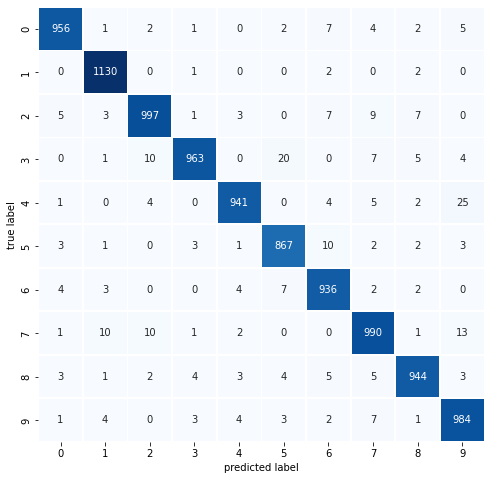

In [143]:
plot_confusion_matrix(y_test,pred_classes_3_5)

# Experiment 4
Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). 

We also reduce the number of dimensions of 'best' model from Experiment 3 to 154 inputs nodes and train it on the new lower dimensional data. 

We then compare the performance of Experiments 3 and 4.

#### Reduce dimensions of training set from 784 to 154

Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154


In [144]:
#Get the dataframe of all the pixel values - TRAIN 
pixel_data = {'actual_class':y_train}
for k in range(0,784): 
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.0,0.0,4.0,1.0,9.0,2.0,1.0,3.0,1.0,4.0,3.0,5.0,3.0,6.0,1.0
pix_val_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pix_val_779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
# Separating out the features - TRAIN
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values 

pca = PCA(n_components=154)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             )
principalDf.head().round(3)

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
0,0.486,-1.226,-0.096,-2.179,-0.107,-0.912,0.918,0.627,-1.426,0.778,...,-0.112,-0.138,-0.159,0.150,0.306,-0.013,0.239,0.003,0.165,0.029
1,3.968,-1.156,2.339,-1.807,-3.244,-0.714,-0.177,-0.412,0.159,0.592,...,0.149,-0.022,0.051,-0.182,0.126,-0.188,0.126,0.105,-0.132,0.097
2,-0.203,1.538,-0.739,2.043,-1.203,-0.007,-3.369,1.445,-0.449,-0.700,...,0.130,-0.322,-0.006,-0.489,-0.019,-0.233,-0.032,0.311,-0.143,0.127
3,-3.134,-2.381,1.073,0.415,-0.007,2.744,-1.858,-0.264,1.187,0.044,...,0.030,-0.052,-0.183,-0.112,0.143,-0.025,-0.055,0.100,0.113,0.060
4,-1.501,2.865,0.064,-0.948,0.385,0.170,-0.359,-1.590,0.884,0.408,...,-0.048,-0.008,-0.013,0.148,-0.288,-0.008,-0.209,0.163,-0.021,-0.204


In [146]:
#Get the dataframe of all the pixel values - TEST
pixel_data_test = {'actual_class':y_test}
for k in range(0,784): 
    pixel_data_test[f"pix_val_{k}"] = x_test_norm[:,k]
pixel_df_test = pd.DataFrame(pixel_data_test)
pixel_df_test.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,7.0,2.0,1.0,0.0,4.0,1.0,4.0,9.0,5.0,9.0,0.0,6.0,9.0,0.0,1.0
pix_val_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pix_val_779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
# Separating out the features - TEST
features_test = [*pixel_data_test][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df_test.loc[:, features_test].values 

principalComponents_test = pca.transform(x)
principalDf_test = pd.DataFrame(data = principalComponents_test
             )
principalDf_test.round(3)

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
0,-1.303,2.933,-0.168,-1.220,-1.943,0.950,1.541,1.846,-1.566,-0.730,...,0.049,0.192,0.148,0.144,0.022,0.086,0.218,-0.208,-0.087,0.047
1,0.081,-3.747,-0.599,1.563,-0.200,-1.845,1.095,0.907,0.577,-0.342,...,0.242,0.104,-0.041,-0.099,0.077,-0.033,0.270,-0.065,0.034,-0.038
2,-3.710,-1.690,0.260,1.020,-2.094,0.345,-0.094,-0.431,0.387,-0.533,...,-0.021,0.071,0.091,-0.229,-0.112,0.012,-0.046,0.165,-0.229,0.015
3,4.839,0.443,0.995,-0.385,-0.818,-1.904,2.728,0.299,0.084,-0.205,...,0.222,0.031,-0.085,0.082,0.109,-0.068,0.100,-0.043,-0.062,0.082
4,0.742,2.802,-1.145,2.476,-0.586,0.881,-1.943,0.929,-1.338,0.763,...,-0.034,0.050,-0.079,0.017,-0.209,-0.015,0.182,-0.081,0.072,0.073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.185,-2.146,-0.146,1.056,3.202,3.730,3.101,0.925,-2.219,-0.147,...,-0.311,0.240,0.219,0.255,0.040,-0.188,-0.055,-0.214,0.034,-0.210
9996,2.258,-2.714,-3.216,-0.753,0.461,-0.793,2.672,3.050,-0.395,-0.158,...,-0.350,-0.237,0.174,-0.034,-0.113,-0.003,-0.111,0.148,-0.092,0.010
9997,-1.060,2.341,1.393,-1.627,2.634,0.639,-0.165,-1.383,-0.097,-3.148,...,0.128,0.082,0.134,0.266,-0.099,-0.111,0.256,-0.301,0.079,-0.039
9998,-1.231,-0.426,2.521,-0.994,-0.577,-1.083,0.636,0.651,1.059,-0.845,...,0.183,0.018,-0.191,-0.097,-0.266,-0.092,-0.015,0.166,-0.087,-0.094


In [148]:
pixel_pca_df = pd.concat([principalDf, pixel_df[['actual_class']]], axis = 1)
pixel_pca_df.round(3)

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,153,actual_class
0,0.486,-1.226,-0.096,-2.179,-0.107,-0.912,0.918,0.627,-1.426,0.778,...,-0.138,-0.159,0.150,0.306,-0.013,0.239,0.003,0.165,0.029,5
1,3.968,-1.156,2.339,-1.807,-3.244,-0.714,-0.177,-0.412,0.159,0.592,...,-0.022,0.051,-0.182,0.126,-0.188,0.126,0.105,-0.132,0.097,0
2,-0.203,1.538,-0.739,2.043,-1.203,-0.007,-3.369,1.445,-0.449,-0.700,...,-0.322,-0.006,-0.489,-0.019,-0.233,-0.032,0.311,-0.143,0.127,4
3,-3.134,-2.381,1.073,0.415,-0.007,2.744,-1.858,-0.264,1.187,0.044,...,-0.052,-0.183,-0.112,0.143,-0.025,-0.055,0.100,0.113,0.060,1
4,-1.501,2.865,0.064,-0.948,0.385,0.170,-0.359,-1.590,0.884,0.408,...,-0.008,-0.013,0.148,-0.288,-0.008,-0.209,0.163,-0.021,-0.204,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.391,-1.151,0.533,-1.361,1.193,0.929,-1.955,-0.932,-1.941,1.256,...,0.087,-0.142,0.289,0.024,0.180,0.024,-0.132,0.250,0.123,8
59996,0.599,-2.698,-0.349,-2.549,0.778,0.725,-1.910,1.982,-2.623,0.106,...,0.147,0.082,-0.209,0.239,-0.052,-0.068,-0.139,-0.225,0.101,3
59997,-0.698,0.628,-1.010,-2.803,-0.825,-1.814,-1.822,-0.725,-0.343,1.051,...,-0.112,-0.197,-0.161,-0.025,-0.399,-0.030,-0.155,-0.005,0.237,5
59998,0.512,-0.022,2.015,1.344,-2.044,-2.120,-0.421,0.552,-0.065,-0.368,...,0.050,0.086,0.162,0.017,-0.033,-0.056,-0.184,-0.124,0.314,6


In [149]:
activation_pca_df = pd.concat([principalDf, activation_df_3_4[['actual_class']]], axis = 1)
activation_pca_df.round(3)

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,153,actual_class
0,0.486,-1.226,-0.096,-2.179,-0.107,-0.912,0.918,0.627,-1.426,0.778,...,-0.138,-0.159,0.150,0.306,-0.013,0.239,0.003,0.165,0.029,5
1,3.968,-1.156,2.339,-1.807,-3.244,-0.714,-0.177,-0.412,0.159,0.592,...,-0.022,0.051,-0.182,0.126,-0.188,0.126,0.105,-0.132,0.097,0
2,-0.203,1.538,-0.739,2.043,-1.203,-0.007,-3.369,1.445,-0.449,-0.700,...,-0.322,-0.006,-0.489,-0.019,-0.233,-0.032,0.311,-0.143,0.127,4
3,-3.134,-2.381,1.073,0.415,-0.007,2.744,-1.858,-0.264,1.187,0.044,...,-0.052,-0.183,-0.112,0.143,-0.025,-0.055,0.100,0.113,0.060,1
4,-1.501,2.865,0.064,-0.948,0.385,0.170,-0.359,-1.590,0.884,0.408,...,-0.008,-0.013,0.148,-0.288,-0.008,-0.209,0.163,-0.021,-0.204,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.391,-1.151,0.533,-1.361,1.193,0.929,-1.955,-0.932,-1.941,1.256,...,0.087,-0.142,0.289,0.024,0.180,0.024,-0.132,0.250,0.123,8
59996,0.599,-2.698,-0.349,-2.549,0.778,0.725,-1.910,1.982,-2.623,0.106,...,0.147,0.082,-0.209,0.239,-0.052,-0.068,-0.139,-0.225,0.101,3
59997,-0.698,0.628,-1.010,-2.803,-0.825,-1.814,-1.822,-0.725,-0.343,1.051,...,-0.112,-0.197,-0.161,-0.025,-0.399,-0.030,-0.155,-0.005,0.237,5
59998,0.512,-0.022,2.015,1.344,-2.044,-2.120,-0.421,0.552,-0.065,-0.368,...,0.050,0.086,0.162,0.017,-0.033,-0.056,-0.184,-0.124,0.314,6


### Best Model 4.3 from Experiment 3

Reduce the number of dimensions of 'best' model from Experiment 3 to 154 inputs nodes and train it on the new lower dimensional data.

#### Build, Compile, Train, Evaluate

In [150]:
## Experiment 3, Variation 4.3 - 100 units, 10 output units, RMSprop optimizer 
## Build model

model_4 = Sequential([
    Dense(input_shape=[154], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_4.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               15500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 16,510
Trainable params: 16,510
Non-trainable params: 0
_________________________________________________________________
None


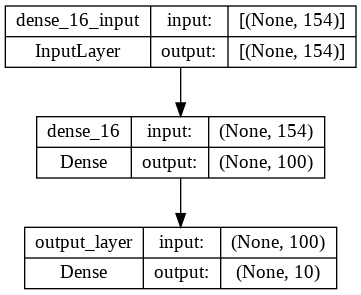

In [151]:
keras.utils.plot_model(model_4, "mnist_model.png", show_shapes=True) 

In [152]:
print(x_train_norm.shape)
print(y_train_encoded.shape)
print(principalDf.shape)
print(x_test_norm.shape)
print(principalDf_test.shape)
print(y_test_encoded.shape)


(60000, 784)
(60000, 10)
(60000, 154)
(10000, 784)
(10000, 154)
(10000, 10)


In [153]:
## Compile

model_4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [154]:
## Train 
## Source: https://github.com/ruchi-kumar

history_4 = model_4.fit(
    principalDf
    ,y_train_encoded
    ,epochs = 200
    ,validation_split= 0.083
    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.4241 - accuracy: 0.9073 - val_loss: 0.2027 - val_accuracy: 0.9610
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2056 - accuracy: 0.9573 - val_loss: 0.1583 - val_accuracy: 0.9731
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1670 - accuracy: 0.9677 - val_loss: 0.1435 - val_accuracy: 0.9755
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1470 - accuracy: 0.9724 - val_loss: 0.1349 - val_accuracy: 0.9767
Epoch 5/200
1720/1720 [==============================] - 4s 3ms/step - loss: 0.1337 - accuracy: 0.9750 - val_loss: 0.1263 - val_accuracy: 0.9787
Epoch 6/200
1720/1720 [==============================] - 4s 3ms/step - loss: 0.1249 - accuracy: 0.9766 - val_loss: 0.1237 - val_accuracy: 0.9775
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1170 - accuracy: 0.9782 - val_loss: 0.1203 - val_ac

In [155]:
## Evaluate
loss, accuracy = model_4.evaluate(principalDf_test, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 0.1273 - accuracy: 0.9742
test set accuracy:  97.42000102996826


##### Predictions and Performance

In [156]:
## Making Predictions 

preds_4 = model_4.predict(principalDf_test)
print('shape of preds: ', preds_4.shape)

313/313 [==============================] - 0s 1ms/step
shape of preds:  (10000, 10)


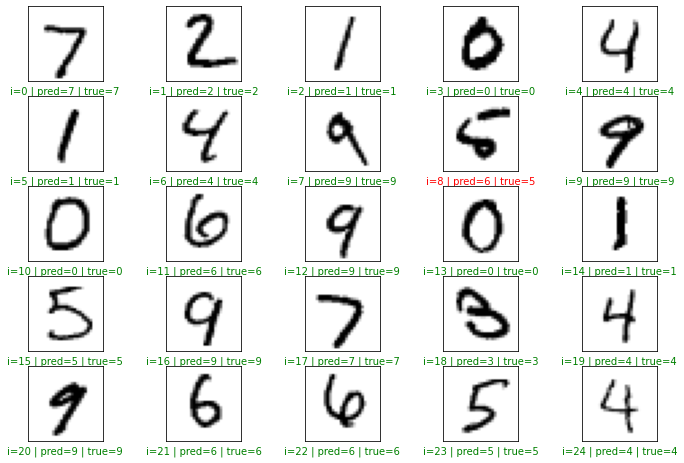

In [157]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred_4 = np.argmax(preds_4[start_index + i])
    actual_4 = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred_4 != actual_4:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred_4, actual_4), color = col) 
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

In [158]:
## Review Performance 

history_dict_4 = history_4.history
history_dict_4.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [159]:
losses = history_4.history['loss']
accs = history_4.history['accuracy']
val_losses = history_4.history['val_loss']
val_accs = history_4.history['val_accuracy']
epochs = len(losses)

In [160]:
history_df_4 =pd.DataFrame(history_dict_4)
history_df_4.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
2,0.167,0.968,0.144,0.976
3,0.147,0.972,0.135,0.977
4,0.134,0.975,0.126,0.979
5,0.125,0.977,0.124,0.978
6,0.117,0.978,0.120,0.978


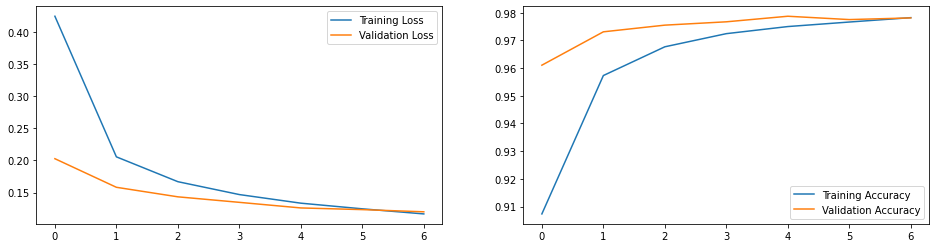

In [161]:
plot_history(history_4)

In [162]:
pred_4= model_4.predict(principalDf_test)
pred_4 =np.argmax(pred_4, axis=1)

print_validation_report(pred_4, pred_4)

313/313 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       993
           1       1.00      1.00      1.00      1143
           2       1.00      1.00      1.00      1038
           3       1.00      1.00      1.00      1014
           4       1.00      1.00      1.00       966
           5       1.00      1.00      1.00       880
           6       1.00      1.00      1.00       964
           7       1.00      1.00      1.00      1021
           8       1.00      1.00      1.00       979
           9       1.00      1.00      1.00      1002

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Accuracy Score: 1.0
Root Mean Square Error: 0.0


In [163]:
## Get the predicted classes:
pred_classes_4 = np.argmax(model_4.predict(principalDf_test), axis=-1)
pred_classes_4;

313/313 [==============================] - 0s 1ms/step


In [164]:
conf_mx_4 = tf.math.confusion_matrix(y_test, pred_classes_4)
conf_mx_4;

In [165]:
## Correlation Matrix
cm_4 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds_4[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm_4)

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.01%,0.21%,0.00%,0.00%,0.00%,99.77%,0.00%,0.01%
1,0.01%,0.00%,99.70%,0.27%,0.00%,0.00%,0.01%,0.00%,0.01%,0.00%
2,0.00%,99.45%,0.17%,0.02%,0.08%,0.02%,0.04%,0.04%,0.17%,0.00%
3,99.93%,0.00%,0.02%,0.00%,0.00%,0.00%,0.01%,0.03%,0.00%,0.00%
4,0.00%,0.00%,0.01%,0.00%,99.78%,0.00%,0.00%,0.03%,0.01%,0.16%
5,0.00%,99.54%,0.02%,0.00%,0.04%,0.00%,0.00%,0.31%,0.10%,0.00%
6,0.00%,0.00%,0.00%,0.00%,99.70%,0.01%,0.00%,0.01%,0.19%,0.09%
7,0.00%,0.00%,0.02%,0.50%,0.12%,0.00%,0.00%,0.05%,0.00%,99.30%
8,0.11%,0.00%,5.06%,0.01%,1.98%,24.17%,67.55%,0.00%,1.02%,0.10%
9,0.00%,0.00%,0.00%,0.00%,0.48%,0.00%,0.00%,0.11%,0.32%,99.08%


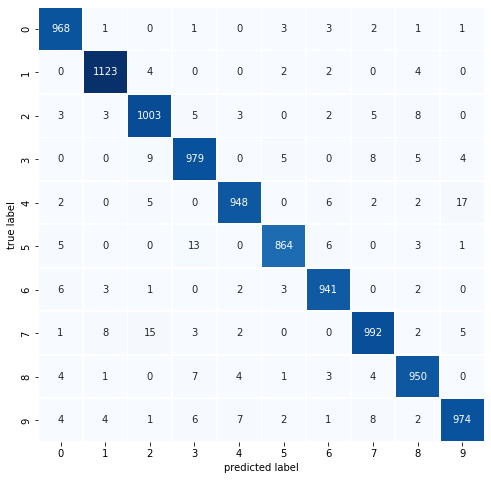

In [166]:
plot_confusion_matrix(y_test,pred_classes_4)

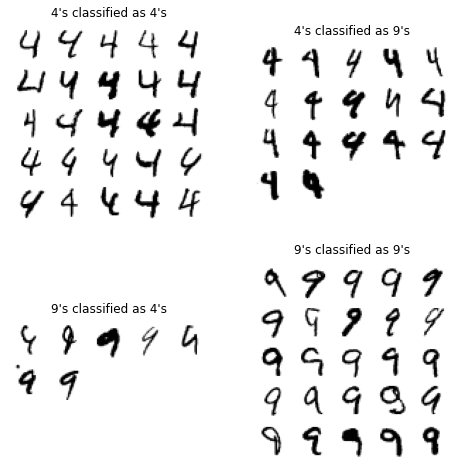

In [167]:
cl_a, cl_b = 4, 9
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes_4 == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes_4 == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes_4 == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes_4 == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);  
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

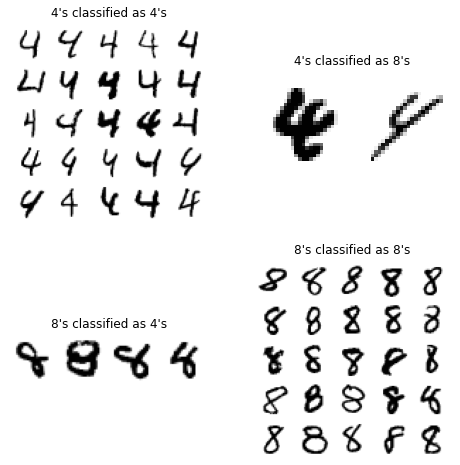

In [168]:
dcl_a, cl_b = 3,8
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes_4 == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes_4 == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes_4 == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes_4 == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);  
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

## Experiment 5

We use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). 

We train our 'best' dense neural network using these 70 features and compare its performance to the the dense neural network models from EXPERIMENTS 3 and 4.

In [169]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(x_train_norm,y_train_encoded)

RandomForestClassifier(random_state=42)

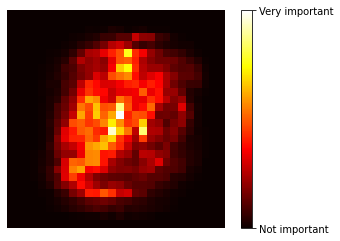

In [170]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

In [171]:
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

In [172]:
## Create training and test examples leveraging 70 pixels

train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]
train_images_sm.shape, test_images_sm.shape # the reduced images have dimension 70

((60000, 70), (10000, 70))

In [173]:
## Visualize the 70 pixels
## We convert the array of indexes to ordered pairs and plot them as red circles on the second training image. These are the features (pixels) we train our neural network on.

# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

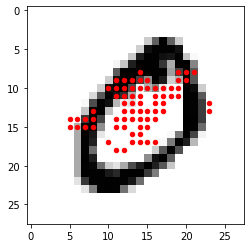

In [174]:
plt.imshow(x_train_norm[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

In [175]:
## Best Model: Experiment 3, Variation 4.3 - 100 units, 10 output units, RMSprop optimizer 
## Build model

model_5 = Sequential([
    Dense(input_shape=[70], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_4.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               15500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 16,510
Trainable params: 16,510
Non-trainable params: 0
_________________________________________________________________
None


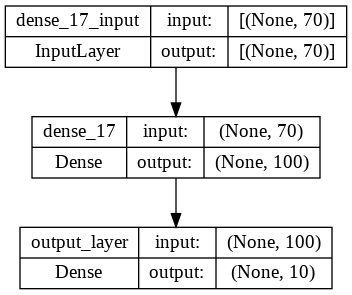

In [176]:
keras.utils.plot_model(model_5, "mnist_model.png", show_shapes=True) 

In [177]:
## Compile

model_5.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [178]:
## Train 

history_5 = model_5.fit(
    train_images_sm ## 70 pixel train set
    ,y_train_encoded
    ,epochs = 200
    ,validation_split= 0.083
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model10.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.7094 - accuracy: 0.8171 - val_loss: 0.4702 - val_accuracy: 0.8817
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.5019 - accuracy: 0.8740 - val_loss: 0.3992 - val_accuracy: 0.9010
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.4344 - accuracy: 0.8901 - val_loss: 0.3494 - val_accuracy: 0.9167
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.3933 - accuracy: 0.9025 - val_loss: 0.3192 - val_accuracy: 0.9289
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.3673 - accuracy: 0.9086 - val_loss: 0.3062 - val_accuracy: 0.9285
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.3487 - accuracy: 0.9129 - val_loss: 0.2900 - val_accuracy: 0.9329
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.3341 - accuracy: 0.9165 - val_loss: 0.2865 - val_ac

In [179]:
## Evaluate

loss, accuracy = model_5.evaluate(test_images_sm, y_test_encoded) ## 70 pixel test set
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 0.3122 - accuracy: 0.9189
test set accuracy:  91.89000129699707


##### Predictions and Performance

In [180]:
## Making Predictions 

preds_5 = model_5.predict(train_images_sm)
print('shape of preds: ', preds_5.shape)

1875/1875 [==============================] - 2s 1ms/step
shape of preds:  (60000, 10)


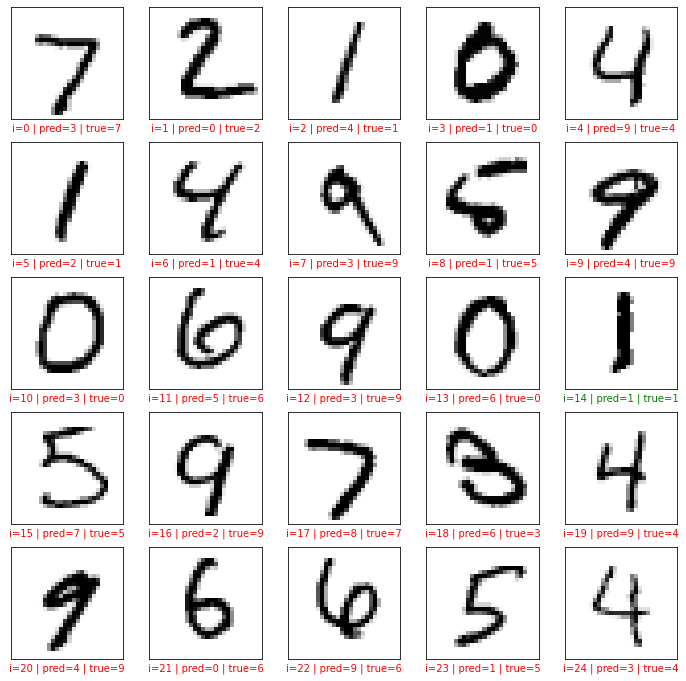

In [181]:
plt.figure(figsize = (12, 12))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred_5 = np.argmax(preds_5[start_index + i])
    actual_5 = np.argmax(y_test_encoded[start_index + i])
    col = 'g' # color of correct prediction
    if pred_5 != actual_5:
        col = 'r' # color of wrong prediction
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred_5, actual_5), color = col) 
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

In [182]:
## Review Performance 

history_dict_5 = history_5.history
history_dict_5.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [183]:
losses = history_5.history['loss']
accs = history_5.history['accuracy']
val_losses = history_5.history['val_loss']
val_accs = history_5.history['val_accuracy']
epochs = len(losses)

In [184]:
history_df_5 =pd.DataFrame(history_dict_5)
history_df_5.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
8,0.314,0.922,0.270,0.938
9,0.306,0.924,0.281,0.933
10,0.301,0.926,0.268,0.938
11,0.295,0.926,0.276,0.935
12,0.291,0.928,0.280,0.934


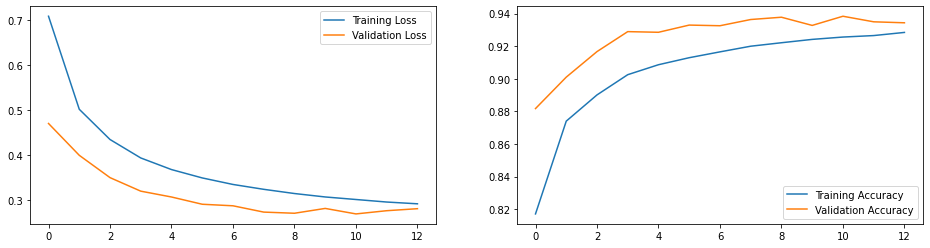

In [185]:
plot_history(history_5)

In [186]:
pred_5= model_5.predict(test_images_sm)
pred_5 =np.argmax(pred_5, axis=1)

print_validation_report(y_test, pred_5)

313/313 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.88      0.91      1032
           3       0.89      0.93      0.91      1010
           4       0.92      0.92      0.92       982
           5       0.91      0.85      0.88       892
           6       0.86      0.97      0.91       958
           7       0.90      0.95      0.92      1028
           8       0.96      0.84      0.90       974
           9       0.88      0.91      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy Score: 0.9189
Root Mean Square Error: 1.1338430226446694


In [187]:
## Get the predicted classes:
pred_classes_5 = np.argmax(model_5.predict(test_images_sm), axis=-1)
pred_classes_5;

313/313 [==============================] - 0s 1ms/step


In [188]:
conf_mx_5 = tf.math.confusion_matrix(y_test, pred_classes_5)
conf_mx_5;

In [189]:
## Correlation Matrix
cm_5 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds_5[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm_5)

,0,1,2,3,4,5,6,7,8,9
0,0.02%,0.05%,0.32%,47.72%,0.07%,39.71%,0.08%,0.31%,1.02%,10.71%
1,99.94%,0.00%,0.00%,0.00%,0.00%,0.01%,0.04%,0.00%,0.00%,0.00%
2,0.00%,0.02%,6.90%,1.25%,52.69%,0.29%,16.57%,3.54%,1.41%,17.32%
3,0.00%,99.45%,0.24%,0.01%,0.02%,0.00%,0.14%,0.13%,0.01%,0.00%
4,0.00%,0.00%,0.03%,0.08%,2.41%,0.01%,0.00%,0.12%,0.16%,97.19%
5,0.00%,0.00%,92.70%,5.07%,0.00%,0.00%,0.00%,1.08%,0.14%,1.00%
6,0.00%,99.28%,0.26%,0.08%,0.01%,0.00%,0.00%,0.08%,0.27%,0.02%
7,0.00%,0.00%,0.06%,99.66%,0.00%,0.00%,0.00%,0.01%,0.04%,0.24%
8,0.00%,98.14%,0.49%,0.75%,0.01%,0.06%,0.01%,0.26%,0.17%,0.10%
9,0.00%,0.00%,0.03%,0.00%,99.85%,0.00%,0.01%,0.06%,0.00%,0.04%


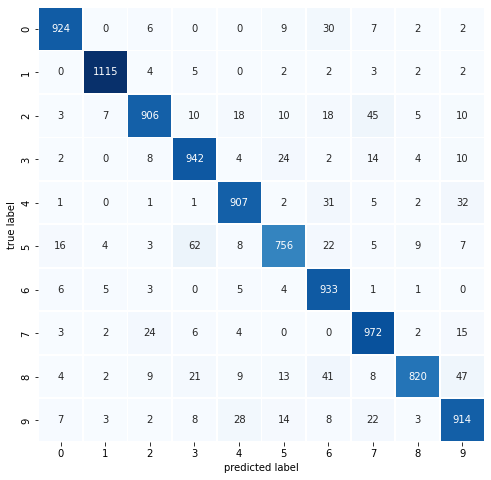

In [190]:
plot_confusion_matrix(y_test,pred_classes_5)

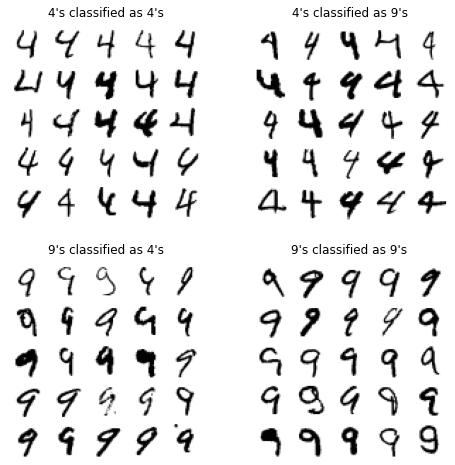

In [191]:
cl_a, cl_b = 4, 9
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes_5 == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes_5 == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes_5 == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes_5 == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);  
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

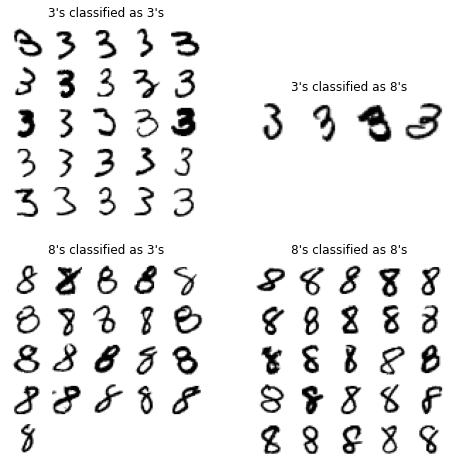

In [192]:
cl_a, cl_b = 3,8
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes_5 == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes_5 == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes_5 == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes_5 == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);  
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

In [ ]:
pixel_pca_df = pd.concat([principalDf, pixel_df[['actual_class']]], axis = 1)

In [ ]:
pixel_pca_df.head().round(3)

,principal component 1,principal component 2,actual_class
0,-0.332,0.035,5
1,-0.246,-0.044,0
2,-0.332,0.035,4
3,-0.332,0.035,1
4,-0.332,0.035,9


In [ ]:
pca.explained_variance_ratio_

array([0.403, 0.164], dtype=float32)

## Use a scatter plot to visualize the predictive power of the two principal component values.

Using seaborn this time...

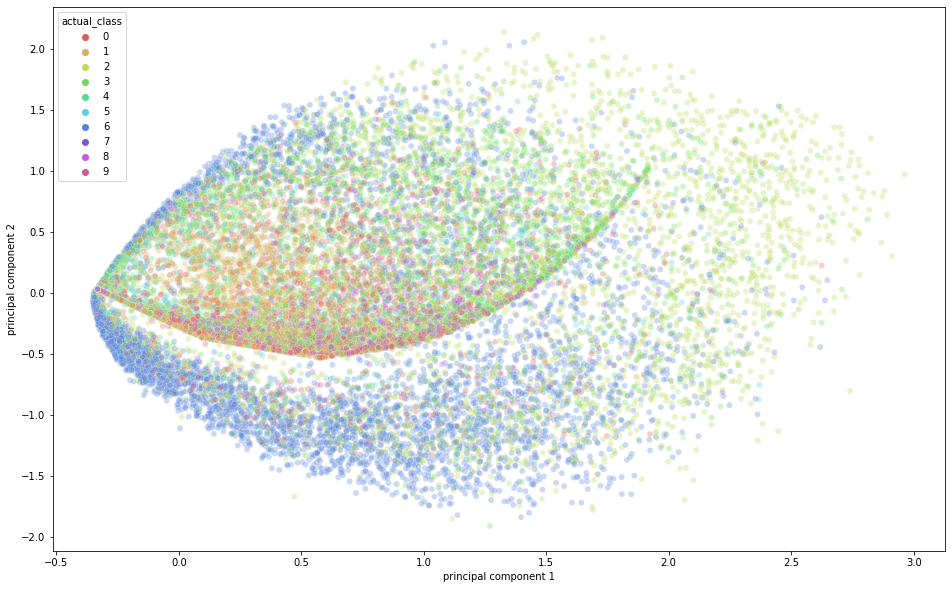

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=pixel_pca_df,
    legend="full",
    alpha=0.3
);

## Use PCA decomposition to reduce the (activation) features from 128 (= num of hidden nodes) to 2

In [ ]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head().round(3)

,principal component 1,principal component 2
0,0.220,-2.195
1,4.248,0.670
2,-0.283,2.075
3,-1.485,-1.874
4,-2.534,2.124


In [ ]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

,principal component 1,principal component 2,actual_class
0,0.220,-2.195,5
1,4.248,0.670,0
2,-0.283,2.075,4
3,-1.485,-1.874,1
4,-2.534,2.124,9


In [ ]:
pca.explained_variance_ratio_

array([0.157, 0.12 ], dtype=float32)

The 2 principal components summed together 0.169 + 0.105 = .274 explained variance 

## Use a scatter plot to visualize the predictive power of *two* principal component values.

Using seaborn this time

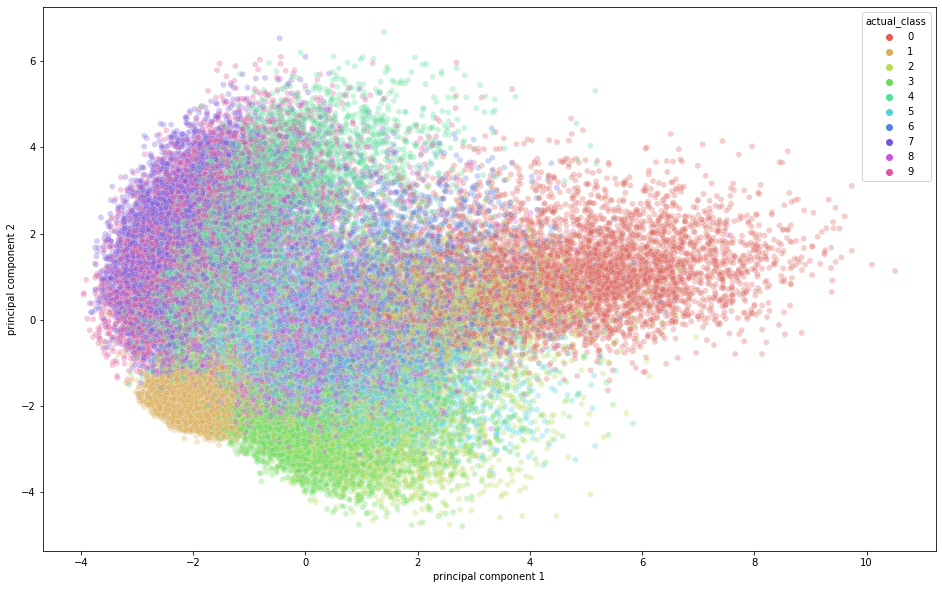

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=activation_pca_df,
    legend="full",
    alpha=0.3
);

### Use PCA decomposition to reduce the (activation) features from 128 (= num of hidden nodes) to 3

In [ ]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca-one', 'pca-two', 'pca-three'])
principalDf.head(10).round(3).T

,0,1,2,3,4,5,6,7,8,9
pca-one,0.220,4.248,-0.283,-1.485,-2.534,0.154,-2.072,1.129,-2.300,-0.817
pca-two,-2.195,0.670,2.075,-1.874,2.124,1.100,-2.027,-1.150,-1.366,2.121
pca-three,-2.016,-0.155,0.455,1.213,-0.919,2.109,0.422,-2.868,0.389,2.642


In [ ]:
pca.explained_variance_ratio_

array([0.157, 0.12 , 0.106], dtype=float32)

The 3 principal components summed together 0.169 + 0.105 + 0.099 = 0.373 explained variance 

In [ ]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

,pca-one,pca-two,pca-three,actual_class
0,0.220,-2.195,-2.016,5
1,4.248,0.670,-0.155,0
2,-0.283,2.075,0.455,4
3,-1.485,-1.874,1.213,1
4,-2.534,2.124,-0.919,9


## Use t-Distributed Stochastic Neighbor Embedding (**t-SNE**)  to reduce the (activation) features from 128 (= num of hidden nodes) to 2

`t-Distributed Stochastic Neighbor Embedding` (**t-SNE**) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. This time we only use the first 10,000 training images (N=10000) since the technique is computationally expensive.

See http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

<div class="alert alert-block alert-info">
    <b>sklearn.manifold.TSNE</b><br> 
    https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
    </div>

In [ ]:
activation_df.shape

(60000, 129)

In [ ]:
N=60000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(60000, 129)

In [ ]:
data_subset = activation_df_subset[features].values
data_subset.shape

(60000, 128)

In [ ]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.006s...
[t-SNE] Computed neighbors for 60000 samples in 75.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

In [ ]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

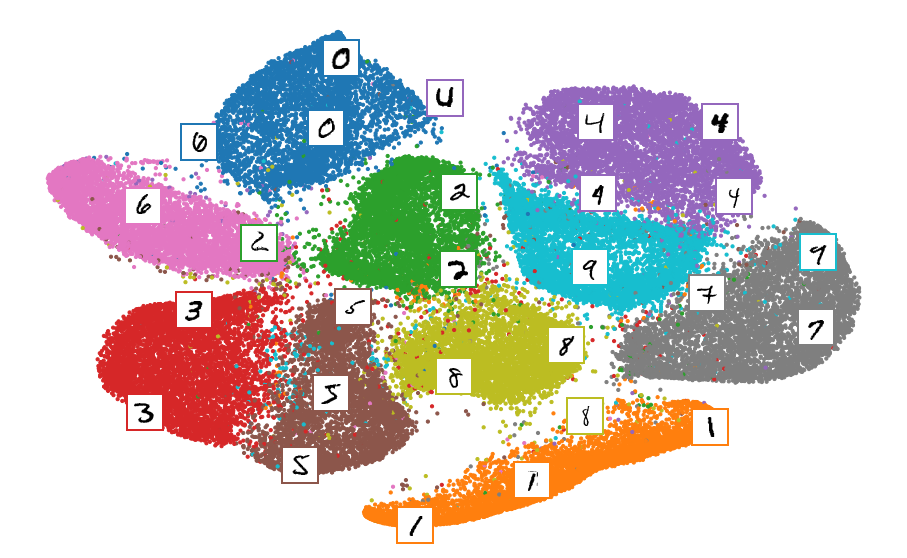

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_train, s=10, cmap=cmap)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_train[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()